# Package & data

In [1]:
import pandas as pd
import numpy as np
import re

In [2]:
## NBA games data

games_details = pd.read_csv("../data/raw/NBA_games_data/games_details.csv")
games = pd.read_csv("../data/raw/NBA_games_data/games.csv")
players = pd.read_csv("../data/raw/NBA_games_data/players.csv")
ranking = pd.read_csv("../data/raw/NBA_games_data/ranking.csv")
teams = pd.read_csv("../data/raw/NBA_games_data/teams.csv")

/var/folders/z4/43xx5g2j0y9cnrwnqycrx5y00000gn/T/ipykernel_88547/1312881547.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  games_details = pd.read_csv("../data/raw/NBA_games_data/games_details.csv")


In [3]:
# Merge 
games_details = games_details.merge(games[['GAME_ID', 'GAME_DATE_EST']], on='GAME_ID', how='left')
new_column_order = ['GAME_DATE_EST'] + [col for col in games_details.columns if col != 'GAME_DATE_EST']
games_details = games_details[new_column_order]

games_details = games_details.astype({'GAME_DATE_EST': 'datetime64[ns]'})

In [4]:
games_details.head()

,GAME_DATE_EST,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,...,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
0,2022-12-22,22200477,1610612759,SAS,San Antonio,1629641,Romeo Langford,Romeo,F,NaN,...,1.0,1.0,2.0,0.0,1.0,0.0,2.0,5.0,2.0,-2.0
1,2022-12-22,22200477,1610612759,SAS,San Antonio,1631110,Jeremy Sochan,Jeremy,F,NaN,...,6.0,3.0,9.0,6.0,1.0,0.0,2.0,1.0,23.0,-14.0
2,2022-12-22,22200477,1610612759,SAS,San Antonio,1627751,Jakob Poeltl,Jakob,C,NaN,...,1.0,3.0,4.0,1.0,1.0,0.0,2.0,4.0,13.0,-4.0
3,2022-12-22,22200477,1610612759,SAS,San Antonio,1630170,Devin Vassell,Devin,G,NaN,...,0.0,9.0,9.0,5.0,3.0,0.0,2.0,1.0,10.0,-18.0
4,2022-12-22,22200477,1610612759,SAS,San Antonio,1630200,Tre Jones,Tre,G,NaN,...,0.0,2.0,2.0,3.0,0.0,0.0,2.0,2.0,19.0,0.0


In [192]:
# Select top 20 players
player_list = [
    "LeBron James", 
    "Stephen Curry", 
    "Kevin Durant", 
    "Kawhi Leonard",
    "Giannis Antetokounmpo",
    "Nikola Jokic", 
    "Joel Embiid", 
    "Luka Doncic", 
    "Anthony Davis", 
    "Damian Lillard",
    "Kyrie Irving", 
    "Chris Paul", 
    "James Harden", 
    "Russell Westbrook", 
    "Klay Thompson",
    "Jayson Tatum", 
    "Ja Morant", 
    "Donovan Mitchell", 
    "Devin Booker",
    "Nikola Vucevic"
]
games_details_best = games_details[games_details['PLAYER_NAME'].isin(player_list)]


In [193]:
# Supression des colonnes
games_details = games_details.drop(columns=['PLAYER_ID', 'GAME_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_CITY', 'NICKNAME', 'COMMENT', 'PLUS_MINUS'], axis=1)


In [194]:
games_details = games_details.sort_values(by='GAME_DATE_EST')


In [195]:
games_details = games_details.dropna(subset=['MIN'])

In [196]:
# Créez une fonction pour harmoniser le format
def harmonize_minutes(minute_str):
    minute_str = str(minute_str)
    
    # Si le format est déjà "mm:ss", retournez la valeur telle quelle
    if re.match(r'^\d{2}:\d{2}$', minute_str):
        return minute_str
    
    # Si le format est "m:ss", ajoutez un "0" devant la minute et retournez "mm:ss"
    match = re.match(r'^(\d+):(\d+)$', minute_str)
    if match:
        minutes, seconds = match.groups()
        return f"0{minutes}:{seconds}"
    
    # Si le format est "m", ajoutez "0" devant la minute pour obtenir "mm:ss"
    if re.match(r'^\d$', minute_str):
        return f"0{minute_str}:00"
    
    
    # Si le format est "m:s", ajoutez "0" devant la minute et retournez "mm:ss"
    if re.match(r'^\d:\d$', minute_str):
        return f"0{minute_str}"

    # Si le format est inconnu, retournez la valeur telle quelle
    return 0

# Appliquez la fonction d'harmonisation à la colonne "MIN"
games_details['MIN'] = games_details['MIN'].apply(harmonize_minutes)


In [197]:
games_details = games_details.loc[games_details['MIN'] != 0]

# Créez une fonction pour convertir "mm:ss" en secondes
def minutes_to_seconds(minute_str):
    minutes, seconds = minute_str.split(':')
    total_seconds = int(minutes) * 60 + int(seconds)
    return total_seconds

# Appliquez la fonction de conversion à la colonne "MIN"
games_details['MIN'] = games_details['MIN'].apply(minutes_to_seconds)
games_details = games_details.rename(columns={'MIN': 'SECOND_PLAYED'})


In [198]:
games_details['START_POSITION'].unique()

array([nan, 'F', 'G', 'C'], dtype=object)

In [199]:
# Extraire l'année de la date
games_details['YEAR'] = games_details['GAME_DATE_EST'].dt.year

# Groupement par année (YEAR) et joueur (PLAYER_NAME)
grouped = games_details.groupby(['YEAR', 'PLAYER_NAME'])


# Définir les colonnes à agréger (addition) et celles à moyenne
agg_columns = {
    'SECOND_PLAYED': 'sum',  # Addition du temps de jeu
    'FGM': 'sum',  # Addition des tirs réussis
    'FGA': 'sum',  # Addition des tentatives de tir
    'FG_PCT': 'mean',  # Moyenne de FG_PCT
    'FG3M': 'sum',  # Addition des tirs à trois points réussis
    'FG3A': 'sum',  # Addition des tentatives de tirs à trois points
    'FG3_PCT': 'mean',  # Moyenne de FG3_PCT
    'FTM': 'sum',  # Addition des lancers francs réussis
    'FTA': 'sum',  # Addition des tentatives de lancers francs
    'FT_PCT': 'mean',  # Moyenne de FT_PCT
    'OREB': 'sum',  # Addition des rebonds offensifs
    'DREB': 'sum',  # Addition des rebonds défensifs
    'REB': 'sum',  # Addition des rebonds totaux
    'AST': 'sum',  # Addition des passes décisives
    'STL': 'sum',  # Addition des interceptions
    'BLK': 'sum',  # Addition des contres
    'TO': 'sum',  # Addition des pertes de balle
    'PF': 'sum',  # Addition des fautes personnelles
    'PTS': 'sum'  # Addition des points marqués
}

# Agrégation pour conserver la "START_POSITION" la plus présente
agg_functions = {
    'START_POSITION': lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0]  # Mode de START_POSITION
}

# Appliquer les opérations d'agrégation
aggregated_data = grouped.agg({**agg_columns, **agg_functions})

# Réinitialiser l'index du DataFrame résultant
aggregated_data = aggregated_data.reset_index()

# Réorganiser les colonnes
new_order = ['YEAR', 'PLAYER_NAME', 'START_POSITION'] + [col for col in aggregated_data.columns if col not in ['YEAR', 'PLAYER_NAME', 'START_POSITION']]
aggregated_data = aggregated_data[new_order]

# Vérifier le résultat
aggregated_data.head()



,YEAR,PLAYER_NAME,START_POSITION,SECOND_PLAYED,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS
0,2003,A.J. Guyton,NaN,300,0.0,4.0,0.000000,0.0,2.0,0.000000,...,1.00000,1.0,1.0,2.0,1.0,1.0,0.0,0.0,2.0,4.0
1,2003,Aaron McKie,G,56913,130.0,279.0,0.441742,43.0,80.0,0.409742,...,0.45429,24.0,101.0,125.0,88.0,45.0,12.0,50.0,66.0,341.0
2,2003,Aaron Williams,C,28450,63.0,128.0,0.448520,0.0,1.0,0.000000,...,0.52408,34.0,79.0,113.0,30.0,13.0,17.0,42.0,59.0,165.0
3,2003,Ademola Okulaja,NaN,300,1.0,1.0,1.000000,0.0,0.0,0.000000,...,0.00000,1.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,2.0
4,2003,Adonal Foyle,NaN,206,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [200]:
aggregated_data['YEAR'] = aggregated_data['YEAR'].astype(int)

In [201]:
# Groupement par année (YEAR)
grouped_by_year = aggregated_data.groupby('YEAR')

# Création de DataFrames séparés pour chaque année
data_année = {}
for year, group in grouped_by_year:
    data_année[year] = group

# Vous obtenez maintenant un dictionnaire de DataFrames, où chaque clé est l'année et la valeur est le DataFrame correspondant
# Par exemple, pour accéder au DataFrame pour l'année 2010, vous pouvez utiliser data_année[2010]
# Accéder au DataFrame pour l'année 2015
data_2015 = data_année[2015]

# Afficher le DataFrame
data_2015.head()


,YEAR,PLAYER_NAME,START_POSITION,SECOND_PLAYED,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS
6724,2015,AJ Price,NaN,4285,9.0,30.0,0.238000,0.0,11.0,0.000000,...,0.000000,1.0,6.0,7.0,12.0,1.0,0.0,2.0,5.0,18.0
6725,2015,Aaron Brooks,G,114097,344.0,852.0,0.389250,129.0,350.0,0.330152,...,0.442739,42.0,155.0,197.0,244.0,53.0,17.0,140.0,195.0,950.0
6726,2015,Aaron Gordon,F,73968,152.0,346.0,0.439217,22.0,79.0,0.161826,...,0.392971,92.0,196.0,288.0,61.0,42.0,42.0,55.0,132.0,403.0
6727,2015,Aaron Harrison,NaN,5969,9.0,23.0,0.468364,7.0,11.0,0.484818,...,0.090909,1.0,10.0,11.0,5.0,4.0,0.0,5.0,7.0,28.0
6728,2015,Adonis Thomas,NaN,582,1.0,2.0,0.500000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0


# MACHINE LEARNING

In [202]:
aggregated_data = aggregated_data.set_index('PLAYER_NAME')


In [203]:
from sklearn import model_selection, preprocessing

from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate, train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns

In [204]:
pl_pos = aggregated_data['START_POSITION']
aggregated_data.drop('START_POSITION', axis=1, inplace=True)


In [205]:
scaler = preprocessing.StandardScaler().fit(aggregated_data)
aggregated_data[aggregated_data.columns] = pd.DataFrame(scaler.transform(aggregated_data), index=aggregated_data.index)
aggregated_data = aggregated_data.join(pd.get_dummies(pl_pos, prefix='pos'))

In [206]:
# Séparation features et target 
data = aggregated_data.drop(['PTS'], axis = 1)
target = aggregated_data.PTS

In [207]:
# Division des matrices 
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=101)

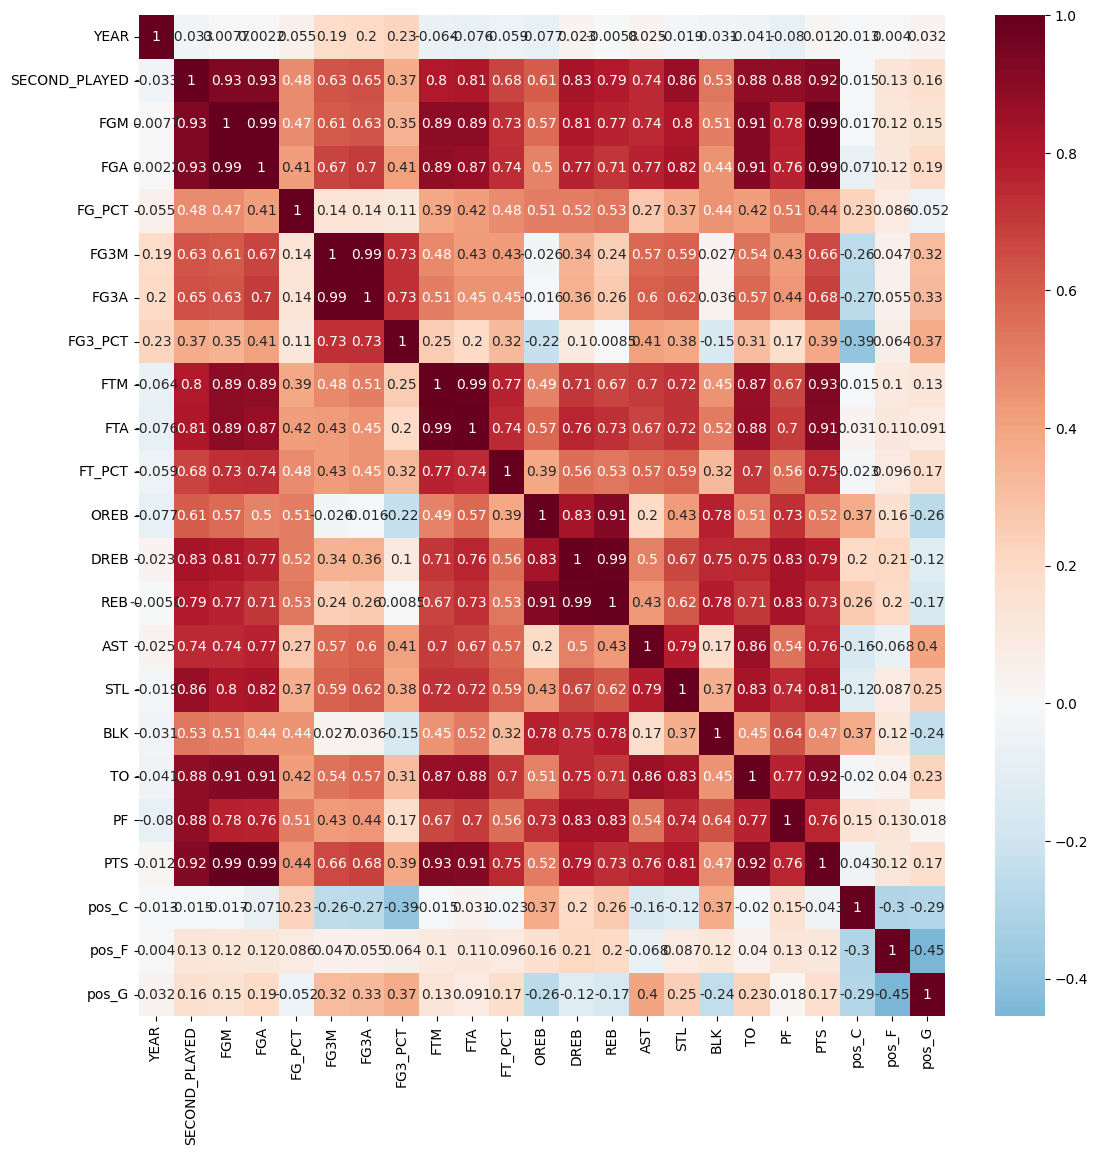

In [208]:
# Affichage d'un heatmap de correlation entre les paires de variables
plt.figure(figsize=(13, 13))
sns.heatmap(aggregated_data.corr(), annot=True, cmap="RdBu_r", center=0);

In [209]:
model_1 = LinearRegression()
model_1.fit(X_train[['SECOND_PLAYED']], y_train)

LinearRegression()

In [210]:
print('score train :', model_1.score(X_train[['SECOND_PLAYED']], y_train))
print('score test :', model_1.score(X_test[['SECOND_PLAYED']], y_test))

pred = model_1.predict(X_train[['SECOND_PLAYED']])
pred_test = model_1.predict(X_test[['SECOND_PLAYED']])

print('rmse train :', np.sqrt(mean_squared_error(y_train, pred)))
print('rmse test :', np.sqrt(mean_squared_error(y_test, pred_test)))

score train : 0.8437516684851981
score test : 0.8466764659745318
rmse train : 0.4321702185967885
rmse test : 0.4305317096094194


In [211]:
from sklearn.linear_model import ElasticNetCV

model_en = ElasticNetCV(cv = 8,
                        l1_ratio=(0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99),
                        alphas=(0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0))

model_en.fit(X_train, y_train)


ElasticNetCV(alphas=(0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0),
             cv=8, l1_ratio=(0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99))

In [212]:
coeffs = list(model_en.coef_)
coeffs.insert(0, model_en.intercept_)
feats = list(data.columns)
feats.insert(0, 'intercept')

pd.DataFrame({'valeur estimée': coeffs}, index=feats)

,valeur estimée
intercept,0.000230
YEAR,0.000000
SECOND_PLAYED,0.000000
FGM,0.726733
FGA,0.003305
FG_PCT,0.000000
FG3M,0.104832
FG3A,0.001536
FG3_PCT,0.000000
FTM,0.210452


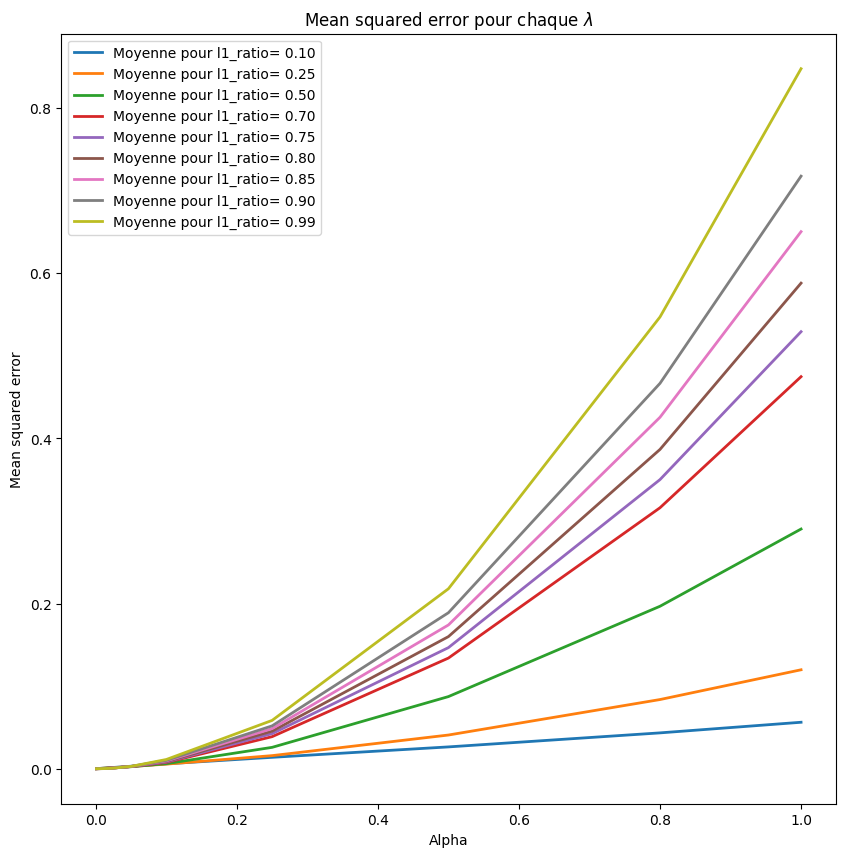

In [213]:
alphas = model_en.alphas_

plt.figure(figsize=(10, 10))

for i in range(model_en.mse_path_.shape[0]) :
    plt.plot(alphas, model_en.mse_path_[i,:,:].mean(axis=1),
             label='Moyenne pour l1_ratio= %.2f' %model_en.l1_ratio[i], linewidth=2)

plt.xlabel('Alpha')
plt.ylabel('Mean squared error')
plt.title('Mean squared error pour chaque $\lambda$')
plt.legend();

In [214]:
pred_train = model_en.predict(X_train)
pred_test = model_en.predict(X_test)
print(np.sqrt(mean_squared_error(y_train, pred_train)))
print(np.sqrt(mean_squared_error(y_test, pred_test)))

0.0012352563912704185
0.001256198718739469


In [215]:
print('score train :', model_en.score(X_train, y_train))
print('score test :', model_en.score(X_test, y_test))

score train : 0.9999987235025953
score test : 0.9999986946853096


In [216]:
moy = scaler.mean_[-1]
ec = scaler.scale_[-1]
print('moyenne :', moy)
print('ecart-type :', ec)

moyenne : 437.76867289096367
ecart-type : 502.0009168940433


In [217]:
pd.DataFrame({'points_observés': (y_test*ec)+moy, 'points_predits' : np.round((pred_test*ec)+moy)}, 
             index=X_test.index).head(7)

,points_observés,points_predits
PLAYER_NAME,,
Cory Joseph,698.0,698.0
Chandler Parsons,763.0,763.0
Justin Jackson,170.0,170.0
Solomon Jones,22.0,22.0
Andre Drummond,1175.0,1176.0
Andray Blatche,574.0,574.0
Othella Harrington,272.0,272.0


In [114]:
import plotly.express as px
fig = px.line(aggregated_data, x='YEAR', y='PTS', color='PLAYER_NAME', title='Points par année par joueur')
fig.show()

In [108]:
filtered_data_2010 = aggregated_data.loc[aggregated_data['YEAR'] == 2010]
filtered_data_2010.head()


,YEAR,PLAYER_NAME,SECOND_PLAYED,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS
19,2010,Chris Paul,122927,336.0,696.0,0.478500,59.0,142.0,0.365768,218.0,...,0.743375,26.0,210.0,236.0,571.0,144.0,3.0,140.0,145.0,949.0
20,2010,James Harden,122225,253.0,605.0,0.407131,111.0,283.0,0.360810,238.0,...,0.622821,35.0,227.0,262.0,139.0,94.0,18.0,108.0,217.0,855.0
21,2010,Kevin Durant,202216,804.0,1737.0,0.467500,148.0,409.0,0.390500,803.0,...,0.902035,98.0,538.0,636.0,238.0,101.0,98.0,273.0,172.0,2559.0
22,2010,LeBron James,203563,812.0,1646.0,0.488195,138.0,407.0,0.334713,664.0,...,0.756816,75.0,569.0,644.0,716.0,141.0,82.0,305.0,153.0,2426.0
23,2010,Russell Westbrook,187511,609.0,1389.0,0.428211,17.0,78.0,0.109267,458.0,...,0.804600,155.0,294.0,449.0,736.0,156.0,31.0,310.0,222.0,1693.0
